# Using scTour to infer cellular dynamics

This notebook uses the endothelial cells collected from mouse brain to show the basic functionalities of scTour.

In [1]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import the data. The raw count matrix and meta information can be downloaded from [here](https://drive.google.com/drive/folders/1zGr_Gqio8zpJWAdLj0g66kN004PyYq_x?usp=sharing).

In [2]:
adata = sc.read('../../../mouse_endo_brain/raw_count_matrix_brain.txt').T
info = pd.read_csv('../../../mouse_endo_brain/Metadata.csv', sep=';', index_col=0)
cells = adata.obs_names.intersection(info.index)
adata = adata[cells, :]
adata.obs['Cluster'] = info.loc[cells, 'Cluster'].copy()
adata.shape

Trying to set attribute `.obs` of view, copying.


(3482, 9340)

Exclude the three clusters: 'choroid plexus', 'artery shear stress', 'interferon', which were similarly excluded in the original publication.

In [3]:
ind = ~np.isin(adata.obs['Cluster'], ['choroid plexus', 'artery shear stress', 'interferon'])
adata = adata[ind, :]

Count the number of genes detected in each cell. This is a necessary step before the scTour model training.

In [4]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.obs

Trying to set attribute `.obs` of view, copying.


,Cluster,n_genes_by_counts,total_counts
AAACCTGTCCGCATAA_brain,capillary venous,1017,1788.0
AAACGGGAGTTTCCTT_brain,capillary venous,1126,2139.0
AAACGGGGTCCAACTA_brain,capillary,1595,3190.0
AAACGGGGTGTTCGAT_brain,capillary venous,1221,2165.0
AAAGATGAGGCTAGAC_brain,capillary venous,1428,2683.0
...,...,...,...
TTTGTCACAGTCCTTC_brain,capillary venous,1647,3281.0
TTTGTCACATCTATGG_brain,large vein,2104,4839.0
TTTGTCAGTCGCGGTT_brain,capillary venous,1642,3456.0
TTTGTCAGTCTCTCGT_brain,capillary arterial,1686,3451.0


Select highly variable genes

In [5]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


log-transform the count before running scTour when you use the "nb" mode

In [6]:
adata.X = np.log1p(adata.X)

Train the scTour model

In [7]:
tnode = sct.train.Trainer(adata, loss_mode='nb')
tnode.train()

Epoch 400: 100%|██████████| 400/400 [11:45<00:00,  1.62s/epoch, train_loss=667, val_loss=658]


Infer the developmental pseudotime

In [8]:
adata.obs['ptime'] = tnode.get_time()

Infer the latent representations. The two parameters alpha_z, and alpha_predz adjust the weights given to the latent z from variational inference and that from ODE solver. Larger alpha_z skews the latent space towards the intrinsic transcriptomic structure while larger alpha_predz is more representative of the extrinsic pseudotime ordering. Users can adjust the two parameters according to their purposes.

In [9]:
#zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
#mix_zs represents the weighted combination of the two, which is used for downstream analysis
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.2, alpha_predz=0.8)

Generate a UMAP embedding based on the inferred latent space. Optionally, you can order the cells according to their pseudotime before this step, which is demonstrated to yield a better trajectory.

In [10]:
adata.obsm['X_TNODE'] = mix_zs
adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

Infer the vector field

In [12]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

Visualize the clusters, pseudotime and vector field on the UMAP generated from scTour's latent space.

... storing 'Cluster' as categorical


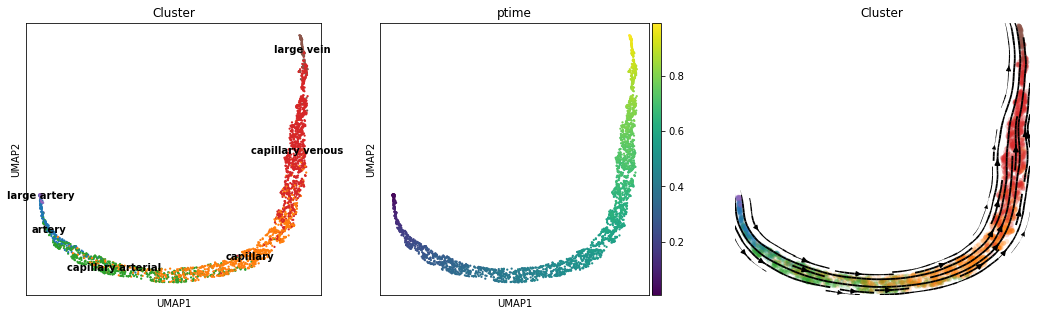

In [13]:
%matplotlib inline
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
sc.pl.umap(adata, color='Cluster', size=20, ax=axs[0], legend_loc='on data', show=False)
sc.pl.umap(adata, color='ptime', size=20, ax=axs[1], show=False)
sct.vf.plot_vector_field(adata, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE', color='Cluster', ax=axs[2], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()                                                                                                